# Step 1: Exploratory Data Analysis

In [123]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# read .cvs files
df = pd.read_csv('train.csv', nrows=1) # nrows=1000
test_df = pd.read_csv('test.csv')

# get target sets
y_train = df["Sentiment"].values
y_test = test_df["Sentiment"].values

In [124]:
# print descriptive statistics of the data, including mean, standard deviation, median, etc.
basic_info = df.describe()
print(basic_info)

       Index  Sentiment
count    1.0        1.0
mean     0.0        0.0
std      NaN        NaN
min      0.0        0.0
25%      0.0        0.0
50%      0.0        0.0
75%      0.0        0.0
max      0.0        0.0


In [125]:
# display the beginning X rows 
print("The data from the first 5 rows are: \n", df.head(5))

# display the bottom X rows 
print("The data from the last 5 rows are: \n", df.tail(5))

The data from the first 5 rows are: 
    Index  Sentiment                                               Text
0      0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
The data from the last 5 rows are: 
    Index  Sentiment                                               Text
0      0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...


In [126]:
# check for missing values; verdict = none
df.isna().sum()

Index        0
Sentiment    0
Text         0
dtype: int64

C:\Users\linya\AppData\Local\Temp\ipykernel_13964\1400134019.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df['Sentiment'], palette='bright')


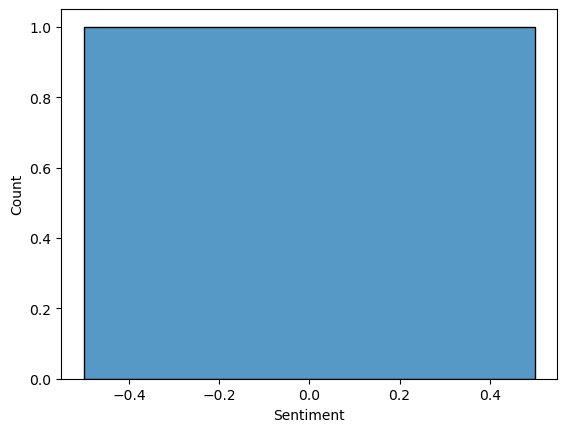

In [127]:
# distribution of negative and positive sentiments
sns.histplot(data=df['Sentiment'], palette='bright')
plt.show()
# much more negative than positive sentiments

# Step 2: Text Preprocessing

In [128]:
import nltk
import contractions
import re

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\linya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\linya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\linya\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [129]:
def tokenize(column):

    # remove '@', 'http', and contractions
    for word in column.split():
      if word.startswith('@'):
        column = column.replace(word, '')
      if word.startswith('http'):
        column = column.replace(word, '')
      if '\'' in word:
        column = column.replace(word, contractions.fix(word))
        # print (word, '->', contractions.fix(word))

    # tokenize, remove punctuation, then stem
    tokens = nltk.word_tokenize(column)
    expanded_tokens = []
    i = 0
    while i < len(tokens):
      # if tokens[i] not in stopwords.words('english'):
      if tokens[i].isalpha():
        expanded_tokens.append(lemmatizer.lemmatize(tokens[i].lower()))
      i += 1

    return expanded_tokens

In [130]:
def join_tokens(column):

    # remove '@', 'http', and contractions
    for word in column.split():
      if word.startswith('@'):
        column = column.replace(word, '')
      if word.startswith('http'):
        column = column.replace(word, '')
      if '\'' in word:
        column = column.replace(word, contractions.fix(word))
        # print (word, '->', contractions.fix(word))

    # tokenize, remove punctuation, then stem
    tokens = nltk.word_tokenize(column)
    expanded_tokens = []
    i = 0
    while i < len(tokens):
      # if tokens[i] not in stopwords.words('english'):
      if tokens[i].isalpha():
        expanded_tokens.append(lemmatizer.lemmatize(tokens[i].lower()))
      i += 1

    return " ".join(expanded_tokens)

In [131]:
df['Tokenized'] = df.apply(lambda x: tokenize(x['Text']), axis=1)
df['Joined Tokens'] = df.apply(lambda x: join_tokens(x['Text']), axis=1)
test_df['Tokenized'] = test_df.apply(lambda x: tokenize(x['Text']), axis=1)
test_df['Joined Tokens'] = test_df.apply(lambda x: join_tokens(x['Text']), axis=1)
df[['Sentiment','Tokenized','Joined Tokens']].head()

,Sentiment,Tokenized,Joined Tokens
0,0,"[awww, that, is, a, bummer, you, shoulda, got,...",awww that is a bummer you shoulda got david ca...


# Step 3: Linguistic Feature Extraction

In [132]:
# Bag of words model
from sklearn.feature_extraction.text import CountVectorizer

corpus = []
for data in df['Joined Tokens']:
    corpus.append(data)

# Create a Count Vectorizer Object
vectorizer  = CountVectorizer()
bow_vector = vectorizer.fit_transform(corpus)

bow_array = bow_vector.toarray()

df['Bag of Words'] = bow_array.tolist()
# df.head()


In [133]:
# TF*IDF model
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = []
for data in df['Joined Tokens']:
    corpus.append(data)

# Create a Tfid Vectorizer Object
vectorizer = TfidfVectorizer()
tf_idf_vector = vectorizer.fit_transform(corpus)

tf_idf_array = tf_idf_vector.toarray()

df['TF*IDF'] = tf_idf_array.tolist()
# df.head()

In [141]:
# word2vec/word embedding model
import gensim
from gensim.models import Word2Vec

words = []
test_words = []

for data in df['Tokenized']:
    words.append(data)
for data in test_df['Tokenized']:
    test_words.append(data)

# CBOW model
cbow = gensim.models.Word2Vec(words, min_count = 1,vector_size = 100, window = 5, sg=0)
cbow_test = gensim.models.Word2Vec(test_words, min_count = 1,vector_size = 100, window = 5, sg=0)
# Skip-gram model
skipgram = gensim.models.Word2Vec(words, min_count = 1,vector_size = 100, window = 5, sg=1)
skipgram_test = gensim.models.Word2Vec(test_words, min_count = 1,vector_size = 100, window = 5, sg=1)

cbow_vector = []
skipgram_vector = []

for data in df['Tokenized']:
    for word in data:
        cbow_vector.append(cbow.wv[word])

for data in df['Tokenized']:
    for word in data:
        skipgram_vector.append(skipgram.wv[word])

# df['CBOW'] = cbow_vector.tolist()
# df.head()

print(len(cbow_vector))

17


# Step 4: Build sentiment classification model

In [135]:
# Import classifiers and metrics from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report

import matplotlib.pyplot as plt

lc = LogisticRegression()
svc = SVC(probability=True)
nbc = GaussianNB()
rfc = RandomForestClassifier()


In [136]:
# # SMOTE for Imbalanced Classification
# from imblearn.over_sampling import SMOTE

# oversample = SMOTE()
# over_sampled_X_train, over_sampled_y_train = oversample.fit_resample(X_train, y_train)

# lc.fit(over_sampled_X_train, over_sampled_y_train)
# svc.fit(over_sampled_X_train, over_sampled_y_train)
# nbc.fit(over_sampled_X_train, over_sampled_y_train)
# rfc.fit(over_sampled_X_train, over_sampled_y_train)

In [137]:
# # Naive Bayes classifier model
# from sklearn import naive_bayes, pipeline, metrics
# classifier = naive_bayes.MultinomialNB()

# ## pipeline
# model = pipeline.Pipeline([("vectorizer", vectorizer),  
#                            ("classifier", classifier)])
# ## train classifier
# model["classifier"].fit(X_train, y_train)
# ## test
# X_test = test_df["Joined Tokens"].values
# predicted = model.predict(X_test)
# predicted_prob = model.predict_proba(X_test)

ValueError: Found input variables with inconsistent numbers of samples: [1000, 1]

In [ ]:
# classes = np.unique(y_test)
# y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
# ## Accuracy, Precision, Recall
# accuracy = metrics.accuracy_score(y_test, predicted)
# auc = metrics.roc_auc_score(y_test, predicted_prob, 
#                             multi_class="ovr")
# print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
# print("Detail:")
# print(metrics.classification_report(y_test, predicted))
    

Accuracy: 0.49
Auc: 0.5
Detail:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       177
           1       0.00      0.00      0.00       182

    accuracy                           0.49       359
   macro avg       0.25      0.50      0.33       359
weighted avg       0.24      0.49      0.33       359



c:\Users\linya\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\linya\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\linya\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# # Logistic Regression
# from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression()

# # with cbow
# train_matrix = cbow.wv.fit_transform(df['Joined Tokens'])
# test_matrix = cbow_test.wv.fit_transform(test_df['Joined Tokens'])

# X_train = train_matrix
# X_test = test_matrix
# y_train = df['Sentiment']
# y_test = test_df['Sentiment']

# lr.fit(X_train, y_train)

# y_pred = lr.predict(X_test)

In [ ]:
# # find accuracy, precision:
# from sklearn.metrics import confusion_matrix,classification_report
# new = np.asarray(y_test)
# confusion_matrix(y_pred,y_test)